# Listing 1
## Finding the best actions given the expected rewards

In [1]:
def get_best_action(actions):
    best_action = 0
    max_action_value = 0
    for i in range(len(actions)): # loops through all possible actions
        curr_action_value = actions[i] # gets the value of the current action
        if curr_action_value > max_action_value:
            best_action = i
            max_action_value = curr_action_value
    return best_action

# Listing 2
## Epsilon-greedy strategy for action selection

In [2]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
import torch

n = 10 # number of arms (number of slot machines)
probs = np.random.rand(n) # hidden probabilities associated with each arm
eps = 0.2 # epsilon for epsilon-greedy action selection

# Listing 3
## Defining the reward function

In [3]:
def get_reward(prob, n=10):
    reward = 0
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

reward_test = [get_reward(0.7) for _ in range(2000)]
np.mean(reward_test)

6.9995

(array([  1.,   4.,  21.,  66., 191., 407., 554., 472., 284.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 9 Patch objects>)

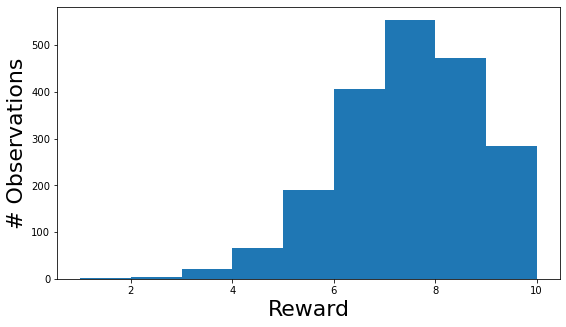

In [4]:
plt.figure(figsize=(9,5))
plt.xlabel("Reward", fontsize=22)
plt.ylabel("# Observations", fontsize=22)
plt.hist(reward_test, bins=9)

# Listing 4
## Updating the reward record

In [8]:
def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

# Listing 5
## Computing the best action

In [9]:
def get_best_arm(record):
    arm_index = np.argmax(record[:, 1], axis=0) # uses numpy argmax on column 1 of the record array
    return arm_index

# Listing 6
## Solving the n-armed bandit

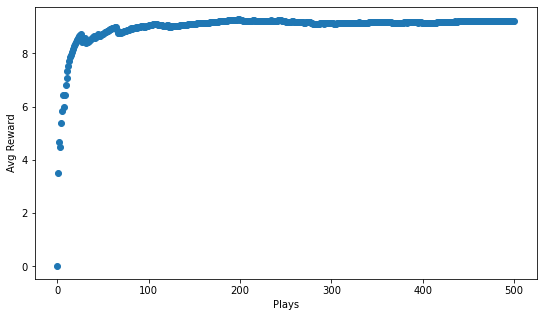

In [11]:
record = np.zeros((n,2)) # initializes the record array to all zeros
rewards = [0]

for i in range(500):
    if random.random() > eps: # chooses the best action with 0.8 probability, or randomly otherwise
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(10)
    r = get_reward(probs[choice]) # computes the reward for choosing the arm
    record = update_record(record, choice, r) # updates the record array with the new count and reward observation for this arm
    mean_reward = ((i + 1) * rewards[-1] + r) / (i + 2) # keeps track of the running average of rewards to assess overall performance
    rewards.append(mean_reward)
    
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
ax.scatter(np.arange(len(rewards)), rewards)

# Listing 7
## The softmax function

In [13]:
def softmax(av, tau=1.12):
    softm = np.exp(av / tau) / np.sum(np.exp(av / tau))
    return softm

# Listing 8
## Softmax action-selection for the n-armed bandit

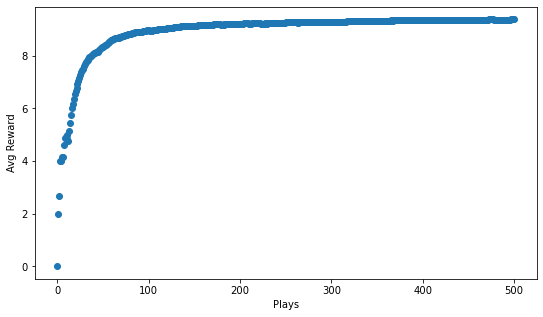

In [14]:
record = np.zeros((n,2))
rewards = [0]

for i in range(500):
    p = softmax(record[:, 1]) # computes softmax probabilities for each arm with respect to their current action values
    choice = np.random.choice(np.arange(n), p=p) # chooses an arm randomly but weighted by the softmax probabilities
    r = get_reward(probs[choice])
    record = update_record(record, choice, r)
    mean_reward = ((i + 1) * rewards[-1] + r) / (i + 2)
    rewards.append(mean_reward)
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
ax.scatter(np.arange(len(rewards)), rewards)

# Listing 9
## Contextual Bandit Environment

In [35]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()

    def init_distribution(self, arms): # number of states = number of arms, to keep things simple. Each row represents a state and each column an arm
        self.bandit_matrix = np.random.rand(arms, arms)

    def reward(self, prob):
        reward = 0
        for _ in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward

    def get_state(self):
        return self.state

    def update_state(self):
        self.state = np.random.randint(0, self.arms)

    def get_reward(self, arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])

    def choose_arm(self, arm): # choosing an arm returns a reward and updates the state
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [36]:
arms = 10
N, D_in, H, D_out = 1, arms, 100, arms
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)
print(state)

3


In [37]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)
loss_fn = torch.nn.MSELoss()
env = ContextBandit(arms)

In [38]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [39]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

# Listing 10
## The main training loop

In [40]:
def train(env, epochs=5000, learning_rate=1e-2):
    curr_state = torch.Tensor(one_hot(arms, env.get_state())) # gets current state of the environment; converts to PyTorch variable
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for _ in range(epochs):
        y_pred = model(curr_state) # runs neural net forward to get reward predictions
        av_softmax = softmax(y_pred.data.numpy(), tau=2.0) # converts reward predictions to probability distribution with softmax
        av_softmax /= av_softmax.sum() # normalizes distribution to make sure it sums to 1
        choice = np.random.choice(arms, p=av_softmax) # chooses new action probabilistically
        curr_reward = env.choose_arm(choice) # takes action, receives reward
        one_hot_reward = y_pred.data.numpy().copy() # converts PyTorch tensor data to numpy array
        one_hot_reward[choice] = curr_reward # updates one_hot_reward array to use as labeled training data
        reward = torch.Tensor(one_hot_reward)
        rewards.append(curr_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_state = torch.Tensor(one_hot(arms, env.get_state())) # updates current environment state
    return np.array(rewards)

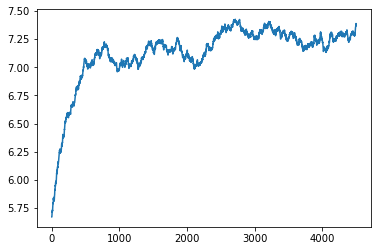

In [41]:
rewards = train(env)
plt.plot(running_mean(rewards,N=500))